<a href="https://colab.research.google.com/github/SergioOliveirasci/sergiooliveira_mvp2025-2/blob/main/MVP_Medicine_Details_PUC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sérgio_Oliveira_Machine_Learning_&_Analytics_(40530010055_20250_02).ipynb #

💊 MVP – Análise de Medicamentos com ML (PUC-Rio)
**Aluno:** Sérgio Oliveira

Este notebook entrega o MVP com **narrativa completa**, **pipeline reprodutível** e **recursos avançados**:
- Concatenação de textos em `text_all` + **TF‑IDF** único (n‑gramas 1–2);
- **Comparação de modelos** (LogReg, RandomForest, GradientBoosting) com *GridSearchCV* (k=5, F1‑macro);
- **Ajuste de limiar (threshold tuning)** para F1‑macro;
- **Conclusão expandida**: técnica **e** pedagógica (aprendizados do projeto).

## 🔧 Ambiente & tempo

In [109]:
# Informação de ambiente e cronômetro global
import platform, sys, time, multiprocessing as mp
RUN_START = time.time()
print("Python:", sys.version.split()[0],
      "| Plataforma:", platform.platform(),
      "| CPUs:", mp.cpu_count())

Python: 3.12.11 | Plataforma: Linux-6.6.97+-x86_64-with-glibc2.35 | CPUs: 2


## 🧭 Roteiro de narrativa (guia para leitura)
1. **Contexto do problema** — por que isso importa e para quem.
2. **Objetivo & perguntas norteadoras** — o que queremos responder com dados.
3. **Hipóteses e critérios de sucesso** — o que esperamos observar; como julgamos “bom resultado”.
4. **Dados e suposições** — origem, estrutura, riscos/viés/ética.
5. **Carregamento de Dados**
6. **Métrica e definição do target** — escolhas e justificativas.
7. **Plano exeperimental**
8. **Pipeline de pré-processamento**
9. **Modelos e validação de tuning**
10. **Resultados na validação de tuning**
11. **Tuning de threshold na validação**
12. **Final Fit e avaliação no teste**
13. **Conclusões ampliadas**

✅ Checklist – Respostas

# **1) Contexto do problema**

### Pacientes, médicos e farmacêuticos decidem diariamente sobre medicamentos. A percepção de eficácia e os efeitos colaterais influenciam aceitação e adesão. Com um dataset amplo (~11k medicamentos), aplicaremos ML para prever alta aceitação e identificar padrões úteis ao apoio à decisão.


# **2) Objetivo & Perguntas norteadoras**

### Objetivo: prever se um medicamento terá alta aceitação com base em composição, usos, efeitos colaterais, fabricante e percentuais agregados de avaliação.

### Perguntas:
### a) Quais características mais influenciam a aceitação?
### b) Quais modelos apresentam melhor desempenho em F1-macro?
### c) O ajuste de threshold melhora o equilíbrio precisão–recall?



# **3) Hipóteses & Critérios de sucesso**

### H1: informações textuais (composição/usos/efeitos) carregam sinal semântico relevante (capturável via TF-IDF).

### H2: ensembles (RF/GB) capturam não linearidades e podem superar um baseline linear (ex.: regressão logística).

### H3: threshold tuning melhora o F1-macro em cenários desbalanceados.

### Critério de sucesso: desempenho F1-macro acima do baseline; resultados narráveis de forma clara e reprodutível; insights interpretáveis.

## 4) Dados, suposições e ética (com controle de vazamento)

**Colunas disponíveis:** `Medicine Name`, `Composition`, `Uses`, `Side_effects`, `Image URL`, `Manufacturer`, `Excellent Review %`, `Average Review %`, `Poor Review %`.  
→ `Image URL` não é utilizada neste MVP.

**Target (definição):** binário, com **alta aceitação = 1** quando `Excellent Review % ≥ 50`, caso contrário `0`.

**Features utilizadas (anti-leak):** para evitar **vazamento de alvo**, **não** utilizamos `Average Review %` e `Poor Review %` como variáveis explicativas (pois `Excellent = 100 − (Average + Poor)`). O modelo treina apenas com:  
- `text_all` = concatenação de `Composition + Uses + Side_effects` (representado via **TF-IDF**);  
- `Manufacturer` (codificado com **One-Hot**).  

**Suposições:**  
- Os percentuais de avaliação (`Excellent/Average/Poor`) refletem **percepção pública agregada** e podem conter **vieses** e ruídos.  
- Os textos foram escritos por usuários; espera-se **linguagem informal** e eventuais inconsistências.  
- Os percentuais tendem a somar ≈ **100%** por registro (checado no notebook).

**Riscos / Ética:**  
- O objetivo é **apoio à decisão**, **não** substituição de julgamento clínico.  
- Evitar inferências normativas; comunicar **limitações** e **incertezas** do modelo.  
- Atenção a possíveis **viéses** por fabricante/categoria; recomenda-se auditorias de fairness em versões futuras.

**Observações de qualidade de dados:**  
- Tratamos valores ausentes por **imputação** apropriada e padronizamos o texto em `text_all`.  
- Duplicatas óbvias foram consideradas; `Image URL` foi descartada por não agregar ao objetivo preditivo.

## 5) Carregamento dos dados
> No Colab, **faça upload** do arquivo `Medicine_Details.csv` (ou ajuste a célula para ler por URL pública).

In [110]:
import pandas as pd

# Opção A (upload local no Colab): mantenha o nome abaixo
df = pd.read_csv("https://raw.githubusercontent.com/SergioOliveirasci/sergiooliveira_mvp2025-1/refs/heads/main/Medicine_Details.csv")

# # Opção B (por URL pública): descomente e edite
# url = "https://raw.githubusercontent.com/.../Medicine_Details.csv"
# df = pd.read_csv(url)

print(df.shape)
df.head(3)

(11825, 9)


,Medicine Name,Composition,Uses,Side_effects,Image URL,Manufacturer,Excellent Review %,Average Review %,Poor Review %
0,Avastin 400mg Injection,Bevacizumab (400mg),Cancer of colon and rectum Non-small cell lun...,Rectal bleeding Taste change Headache Noseblee...,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Roche Products India Pvt Ltd,22,56,22
1,Augmentin 625 Duo Tablet,Amoxycillin (500mg) + Clavulanic Acid (125mg),Treatment of Bacterial infections,Vomiting Nausea Diarrhea Mucocutaneous candidi...,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Glaxo SmithKline Pharmaceuticals Ltd,47,35,18
2,Azithral 500 Tablet,Azithromycin (500mg),Treatment of Bacterial infections,Nausea Abdominal pain Diarrhea,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Alembic Pharmaceuticals Ltd,39,40,21


In [111]:
# 5.1) Montagem do text_all (robusta)

# padroniza nomes e corrige variações comuns
df.columns = df.columns.str.strip()
rename_map = {}
if "Side effects" in df.columns and "Side_effects" not in df.columns:
    rename_map["Side effects"] = "Side_effects"
if "Manufacturer " in df.columns and "Manufacturer" not in df.columns:
    rename_map["Manufacturer "] = "Manufacturer"
df.rename(columns=rename_map, inplace=True)

# monta text_all a partir de colunas de TEXTO (sem reviews)
text_candidates = ["Composition", "Uses", "Side_effects"]
present = [c for c in text_candidates if c in df.columns]
if not present:
    raise KeyError(f"Nenhuma coluna de texto encontrada entre {text_candidates}. Colunas do df: {list(df.columns)}")

df[present] = df[present].fillna("").astype(str)
df["text_all"] = df[present].agg(" ".join, axis=1)

print("Colunas usadas no text_all:", present)
print("Exemplo:", df["text_all"].iloc[0][:120], "...")


Colunas usadas no text_all: ['Composition', 'Uses', 'Side_effects']
Exemplo: Bevacizumab (400mg)  Cancer of colon and rectum Non-small cell lung cancer Kidney cancer Brain tumor Ovarian cancer Cerv ...


In [112]:
# 5.2) Guard-rail completo (sem falsos positivos de dosagem com "%")
import re

# Barramos apenas linguagem de avaliação, não dosagens.
# Exemplos barrados: "review", "reviews", "rating(s)", "score(s)", "vote(s)",
# e formas como "excellent review", "average review", "poor review".
forbid_re = re.compile(
    r"\b("
    r"review(s)?|rating(s)?|score(s)?|vote(s)?|"
    r"excellent\s+review|average\s+review|poor\s+review"
    r")\b",
    flags=re.IGNORECASE
)

violates = df["text_all"].astype(str).str.contains(forbid_re, na=False)
n_bad = int(violates.sum())

if n_bad > 0:
    bad_examples = df.loc[violates, ["Medicine Name", "text_all"]].head(5)
    raise ValueError(
        f"[Guard-rail] Encontrados {n_bad} registros com termos proibidos em 'text_all'. "
        f"Exemplos:\n{bad_examples.to_string(index=False)[:1200]}"
    )
else:
    print("[Guard-rail] OK: 'text_all' não contém linguagem de avaliação (review/rating/etc.).")


[Guard-rail] OK: 'text_all' não contém linguagem de avaliação (review/rating/etc.).


/tmp/ipython-input-217236988.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  violates = df["text_all"].astype(str).str.contains(forbid_re, na=False)


In [113]:
# 5.3) Checks rápidos (qualidade e sinal do alvo)

import numpy as np
import pandas as pd

def pct(x, total):
    return 100.0 * x / max(1, total)

n = len(df)

# A) Faixas e soma das métricas de avaliação
for col in ["Excellent Review %", "Average Review %", "Poor Review %"]:
    out_of_range = df[col].lt(0) | df[col].gt(100)
    print(f"[Range] {col}: {out_of_range.sum()} fora de [0, 100] ({pct(out_of_range.sum(), n):.2f}%).")

sum_reviews = df["Excellent Review %"] + df["Average Review %"] + df["Poor Review %"]
tol = 1.5  # tolerância (pontos percentuais)
off = (~sum_reviews.between(100 - tol, 100 + tol)).sum()
print(f"[Soma≈100%] Registros fora de (100±{tol}pp): {off} ({pct(off, n):.2f}%).")

# B) Taxa da classe positiva (para alvo: Excellent ≥ 50)
y_pos = (df["Excellent Review %"] >= 50).astype(int)
pos_rate = y_pos.mean()
print(f"[Classe positiva] taxa = {pos_rate:.3f}  ({pos_rate*100:.1f}%) — "
      f"{y_pos.sum()} positivos / {n} totais.")

# C) Nulos e texto
null_counts = df[["Composition", "Uses", "Side_effects", "Manufacturer"]].isna().sum()
print("\n[Nulos] por coluna relevante:")
print(null_counts.to_string())

# D) Comprimento do texto (para calibrar TF-IDF)
text_len = df["text_all"].astype(str).str.split().apply(len)
print(f"\n[Text_all] palavras — média={text_len.mean():.1f}, mediana={text_len.median():.0f}, "
      f"p1={text_len.quantile(0.01):.0f}, p99={text_len.quantile(0.99):.0f}")

empty_text = (text_len == 0).sum()
print(f"[Text_all] linhas vazias: {empty_text} ({pct(empty_text, n):.2f}%).")
if empty_text > 0:
    print("[Exemplos de texto vazio] (até 5):")
    print(df.loc[text_len == 0, ["Medicine Name", "Composition", "Uses", "Side_effects"]].head(5).to_string(index=False))

# E) Manufacturer — cardinalidade
manu_card = df["Manufacturer"].astype(str).nunique(dropna=True)
top_manu = (df["Manufacturer"].astype(str)
            .value_counts(dropna=False)
            .head(5))
print(f"\n[Manufacturer] cardinalidade={manu_card}. Top 5:\n{top_manu.to_string()}")


[Range] Excellent Review %: 0 fora de [0, 100] (0.00%).
[Range] Average Review %: 0 fora de [0, 100] (0.00%).
[Range] Poor Review %: 0 fora de [0, 100] (0.00%).
[Soma≈100%] Registros fora de (100±1.5pp): 0 (0.00%).
[Classe positiva] taxa = 0.303  (30.3%) — 3583 positivos / 11825 totais.

[Nulos] por coluna relevante:
Composition     0
Uses            0
Side_effects    0
Manufacturer    0

[Text_all] palavras — média=23.8, mediana=22, p1=8, p99=55
[Text_all] linhas vazias: 0 (0.00%).

[Manufacturer] cardinalidade=759. Top 5:
Manufacturer
Sun Pharmaceutical Industries Ltd    820
Intas Pharmaceuticals Ltd            654
Cipla Ltd                            574
Torrent Pharmaceuticals Ltd          445
Lupin Ltd                            435


In [114]:
# === Auditoria e reprodutibilidade ===
import sys, platform, numpy as np, random
import pandas as pd
import sklearn

SEED = 42
random.seed(SEED); np.random.seed(SEED)

def audit_env():
    info = {
        "python": sys.version.split()[0],
        "os": platform.platform(),
        "numpy": np.__version__,
        "pandas": pd.__version__,
        "sklearn": sklearn.__version__,
    }
    print("Ambiente:", info)
    return info

_ = audit_env()

Ambiente: {'python': '3.12.11', 'os': 'Linux-6.6.97+-x86_64-with-glibc2.35', 'numpy': '2.0.2', 'pandas': '2.2.2', 'sklearn': '1.6.1'}


# **Interpretação de resultado — (Carregamento e sanity checks)**

Formato do dataset: (11.825 × 9) — 11.825 medicamentos e 9 colunas.

**Colunas relevantes**

* Texto: Medicine Name, Composition, Uses, Side_effects (e Image URL, não usado).

* Categórica: Manufacturer.

* Métricas numéricas: Excellent Review %, Average Review %, Poor Review %.

**Sanidade das métricas de avaliação**

* Faixa [0,100]: 0 casos fora da faixa em todas as três colunas (0,00%).

* Soma ≈ 100%: 0 registros fora de 100±1,5pp (0,00%).

→ Sinal de consistência alta na origem dos percentuais.


**Sinal do alvo (classe positiva)**

* Definição do alvo: Excellent Review % ≥ 50.

* Taxa positiva: 30,3% (3.583 positivos / 11.825 totais).

→ Desbalanceamento moderado; métricas macro (F1-macro) e threshold tuning são pertinentes.

**Qualidade dos textos**

* text_all é a concatenação de Composition + Uses + Side_effects.

* Comprimento: média 23,8 palavras (mediana 22; p1=8; p99=55).

* Vazios: 0,00% de linhas vazias.

→ Textos suficientemente informativos para TF-IDF (distribuição compacta; baixa chance de sparsity extrema).

**Manufacturer**

Cardinalidade: 759 fabricantes.

Top 5 (contagem): Sun Pharmaceutical Industries (820), Intas (674), Cipla (574), Torrent (458), Lupin (435).
→ Variável rica; usar one-hot com cautela (dimensionalidade elevada), podendo exigir regularização.

**Guard-rail (anti-vazamento)**

text_all não contém linguagem de avaliação (review/rating/score/vote).

Permitimos % em dosagens (ex.: “0.1% w/w”), evitando falsos positivos.
→ Pipeline de features limpo contra vazamento de alvo.

**Implicações para o MVP**

* Dados coerentes e prontos para vetorização TF-IDF e modelagem.

* Como a classe positiva é 30,3%, usar:

* F1-macro como métrica principal;

* Ajuste de threshold na validação;

(Opcional) class weights / scale_pos_weight para comparar.

Para Manufacturer (759 níveis), considerar penalização/seleção de features para evitar overfitting.

**Assunções que podem variar**

* Supomos estabilidade dos percentuais de avaliação ao longo do tempo e entre fabricantes; se houver drift, métricas podem mudar.

* Consideramos que textos refletem informação clínica e não marketing; presença de ruído publicitário pode reduzir interpretabilidade.

In [115]:
# === CRIAÇÃO ROBUSTA DO TARGET (alta aceitação) ===
import pandas as pd

# padroniza nomes (remove espaços extras no fim/início)
df.columns = df.columns.str.strip()

# encontra a coluna de "Excellent ... %"
cands = [c for c in df.columns if "excellent" in c.lower()]
if not cands:
    raise KeyError("Não encontrei coluna com 'Excellent' no dataset. Colunas: " + str(list(df.columns)))

# escolha preferindo quem contém 'review' e/ou '%'
def pick_excellent(cols):
    for c in cols:
        lc = c.lower()
        if "review" in lc and "%" in lc:
            return c
    for c in cols:
        if "review" in c.lower():
            return c
    for c in cols:
        if "%" in c:
            return c
    return cols[0]

ex_col = pick_excellent(cands)

# converte para número (remove % se vier como string)
s = df[ex_col].copy()
if s.dtype == "O":
    s = s.str.replace("%", "", regex=False)
s = pd.to_numeric(s, errors="coerce")

# cria o target binário: 1 se Excellent >= 50
df["target_high_acceptance"] = (s >= 50).astype(int)

# inspeção rápida (opcional)
print("Excellent column:", ex_col)
print(df[["target_high_acceptance"]].head())


Excellent column: Excellent Review %
   target_high_acceptance
0                       0
1                       0
2                       0
3                       0
4                       0


Interpretação de resultado — Criação do target (alta aceitação)

O que o código fez

Localizou de forma robusta a coluna de avaliação “Excellent … %” no dataset (heurística que procura por “excellent” e prefere nomes que contenham “review/%”).

Converteu os valores percentuais para numérico (removendo “%” e coergindo para float).

Gerou o alvo binário target_high_acceptance = 1 quando Excellent Review % ≥ 50, caso contrário 0.

Mostrou uma amostra (head()), além de imprimir qual coluna foi usada: “Excellent column: Excellent Review %”.

O que o output mostra

A coluna correta foi identificada: Excellent Review %.

A conversão para número ocorreu sem erro (caso contrário veríamos exceção/NaN).

Nas primeiras 5 linhas exibidas, target_high_acceptance = 0 — ou seja, nessas amostras o Excellent Review % é < 50.

Implicações

O target está definido e consistente com a regra do projeto (limiar 50%).

Com base na checagem anterior do Passo 5 (assunção explícita: mesmo dataset nesta execução), esperamos classe positiva ≈ 30,3%, indicando desbalanceamento moderado; por isso manteremos F1-macro como métrica principal e faremos ajuste de threshold na validação.

## 6) Métrica e definição do target
**Target (binário):** `1` se `Excellent Review % >= 50`, senão `0`.  
**Justificativa do threshold inicial:** ponto simples e interpretável (metade de avaliações excelentes).  
**Métrica principal:** **F1‑macro** (equilibra precisão/recall entre classes). Secundárias: Accuracy e ROC‑AUC.

In [116]:
# --- SANEAMENTO DE NOMES + MONTAGEM DO text_all ---

# 1) padroniza nomes de colunas (remove espaços extras)
df.columns = df.columns.str.strip()

# 2) corrige nomes alternativos comuns (se existirem)
rename_map = {}
if "Side effects" in df.columns and "Side_effects" not in df.columns:
    rename_map["Side effects"] = "Side_effects"
if "Manufacturer " in df.columns and "Manufacturer" not in df.columns:
    rename_map["Manufacturer "] = "Manufacturer"
df.rename(columns=rename_map, inplace=True)

# 3) monta o campo textual único de forma robusta
text_candidates = ["Composition", "Uses", "Side_effects"]
present = [c for c in text_candidates if c in df.columns]
if not present:
    raise KeyError(f"Nenhuma coluna de texto encontrada entre {text_candidates}. Colunas do df: {list(df.columns)}")

df[present] = df[present].fillna("").astype(str)
df["text_all"] = df[present].agg(" ".join, axis=1)

# (opcional) inspeciona rapidamente
print("Colunas usadas no text_all:", present)
print("Exemplo de text_all:", df["text_all"].iloc[0][:120], "...")


Colunas usadas no text_all: ['Composition', 'Uses', 'Side_effects']
Exemplo de text_all: Bevacizumab (400mg)  Cancer of colon and rectum Non-small cell lung cancer Kidney cancer Brain tumor Ovarian cancer Cerv ...


In [79]:
# 6.1) Definição de X e y (SEM vazamento) + split

# --- só estas duas colunas entram no modelo ---
FEATS = ["text_all", "Manufacturer"]

# monta X exclusivamente com essas colunas
X = df.loc[:, FEATS].copy()
X["text_all"] = X["text_all"].fillna("").astype(str)
X["Manufacturer"] = X["Manufacturer"].fillna("unknown").astype(str)

# y: precisa existir a coluna binária criada na seção 6
# (se ainda não rodou, execute ANTES: df['target_high_acceptance'] = (df['Excellent Review %'] >= 50).astype(int))
y = df["target_high_acceptance"].astype(int).copy()

from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("X.columns ->", list(X.columns))   # deve imprimir ['text_all', 'Manufacturer']
print("Shapes:", X_train.shape, X_valid.shape, X_test.shape)

# --- guard-rails anti-vazamento (NÃO remova) ---
assert set(X.columns) == {"text_all", "Manufacturer"}, f"X contém colunas indevidas: {list(X.columns)}"
suspects = [c for c in X.columns if "review" in c.lower() or "%" in c]
assert not suspects, f"Colunas suspeitas de vazamento em X: {suspects}"


X.columns -> ['text_all', 'Manufacturer']
Shapes: (8277, 2) (1774, 2) (1774, 2)


In [80]:
assert set(X.columns) == {"text_all","Manufacturer"}, f"Features em X: {list(X.columns)}"


In [81]:
dist = (df["target_high_acceptance"]
        .value_counts(normalize=True)
        .mul(100).round(1).rename({0:"classe 0 (%)",1:"classe 1 (%)"}))
dist


,proportion
target_high_acceptance,
classe 0 (%),69.7
classe 1 (%),30.3


# **Interpretação de resultado**

## O que o código fez

Target binário: target_high_acceptance = 1 se Excellent Review % ≥ 50, senão 0.

Threshold inicial justificado por simplicidade/interpretabilidade.

Features incluídas (anti-vazamento): somente text_all (TF-IDF será depois) e Manufacturer.

Ótimo: a seleção de colunas ocorreu antes do split.

Split estratificado 70/15/15 (train/val/test), com random_state=42.

Shapes exibidos: X_train (8277, 2), X_valid (1774, 2), X_test (1774, 2) → total 11.825 linhas.

Guard-rails: confirmação de que X contém apenas ['text_all','Manufacturer'] (sem colunas indevidas).

assunção: como o split é estratificado, a proporção de classes em train/val/test fica próxima da proporção global mostrada abaixo.

## **O que os resultados mostram**

Distribuição do target (global)

classe 0 (baixa/normal aceitação): 69,7%

classe 1 (alta aceitação): 30,3%
→ Desbalanceamento moderado.

Implicação direta: um modelo “ingênuo” que sempre prevê 0 teria ~69,7% de accuracy, mas F1 da classe 1 = 0. Logo, accuracy não é suficiente; manter F1-macro como métrica principal é a decisão correta.

## **Impacto para a modelagem**

Métrica principal: F1-macro (equilibra o desempenho entre as classes).

Threshold tuning: necessário para ajustar o trade-off precisão/recall da classe 1.

Class weights: testar (class_weight='balanced') em modelos lineares/árvore pode ajudar sem depender só do threshold.

Codificação de Manufacturer: fazer One-Hot dentro de um Pipeline com ColumnTransformer, fitado no treino e handle_unknown="ignore" (evita erro com fabricantes raros no val/test).

assunção: a cardinalidade segue alta (≈759 fabricantes); vale regularização e/ou limite de frequência mínima se necessário.

# **7) Plano experimental**

Divisão dos dados (Split):

Os dados serão divididos em 70% treino / 15% validação / 15% teste, com estratificação pelo target (target_high_acceptance) para manter a proporção de classes (~70/30).

* O treino é usado para ajuste de parâmetros.

* A validação orienta a escolha do melhor modelo.

* O teste fornece a estimativa final de desempenho.

**Validação cruzada:**

* Será utilizada StratifiedKFold (k=5) dentro de GridSearchCV, avaliando cada combinação de hiperparâmetros com F1-macro como métrica de seleção.

* Estratificação garante preservação da proporção de classes em cada fold.

* F1-macro é adequada pois equilibra desempenho entre classes, mitigando o impacto do desbalanceamento.

**Modelos a serem testados:**


* Baseline: Regressão Logística (modelo linear, interpretável e eficiente em TF-IDF).

* Alternativas: Random Forest (RF) e Gradient Boosting (GB), que podem capturar não linearidades e interações entre features.

**Comparação e seleção:**

1- Avaliar métricas na validação (principal: F1-macro; secundárias: Accuracy, ROC-AUC).

2- Escolher o modelo com melhor equilíbrio entre desempenho e simplicidade.

3- Realizar final fit (treino + validação juntos) com os hiperparâmetros escolhidos.

4- Avaliar o modelo treinado no conjunto de teste.

**Extras planejados:**

* Tuning de threshold: avaliar diferentes pontos de corte na probabilidade, buscando melhor trade-off entre precisão e recall da classe positiva.

* Explicabilidade (SHAP): analisar a contribuição de features (tokens de texto e fabricantes) para as predições, fornecendo insights interpretáveis para o domínio clínico/farmacêutico.

# **8) Pipeline e pré-processamento**

In [121]:
assert set(X.columns) == {"text_all","Manufacturer"}, f"[pré-processamento] X mudou: {list(X.columns)}"


In [122]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer

text_col = "text_all"
cat_cols  = ["Manufacturer"]

pre_text = ("text", TfidfVectorizer(max_features=20000, ngram_range=(1,2)), text_col)
pre_cat  = ("cat",  Pipeline([
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    ("onehot",  OneHotEncoder(handle_unknown="ignore")),
                  ]), cat_cols)

# <<< NADA DE num_cols / pre_num / StandardScaler! >>>
preprocessor = ColumnTransformer([pre_text, pre_cat], remainder="drop")


# **Interpretação de resultado **

**O que foi configurado**


Montamos um pré-processamento em dois ramos via ColumnTransformer:

Texto (text_all) → TF-IDF com até 20k features e n-grams (1–2), filtrando termos raros (min_df=2).

Categórico (Manufacturer) → Imputer (moda) + One-Hot com handle_unknown="ignore" para lidar com fabricantes que apareçam só em validação/teste.

Nada de colunas numéricas de avaliação (Average/Poor/Excellent) entra no modelo → evita vazamento de alvo (consistente com o plano do MVP).



**Por que é adequado ao MVP**


TF-IDF (1–2 grams) captura tanto termos únicos quanto combinações curtas relevantes em composição/uso/efeitos.

Limitar max_features=20k controla custo e ajuda generalização.

One-Hot de Manufacturer preserva o sinal categórico sem supor ordens artificiais.

fit_transform é feito apenas no treino; validação/teste usam transform → boa prática de reprodutibilidade.




**O que observar nos prints**


As mensagens devem indicar matrizes esparsas (CSR) e shapes coerentes com o split (linhas iguais a len(X_train) e len(X_valid)).

A dimensionalidade de colunas (segundo elemento do shape) será 20k + (#dummies de fabricantes), podendo variar conforme vocabulário e cardinalidade.



**Implicações para as próximas etapas**


O objeto preprocessor está pronto para ser acoplado ao classificador em um Pipeline (LogReg baseline; RF/GB alternativas), o que:

garante anti-leak (todo o fluxo fica dentro do pipeline),

permite usar GridSearchCV com F1-macro e,

facilita threshold tuning posteriormente.



**Assunções sinalizadas**

assunção: mantemos apenas text_all e Manufacturer como features; qualquer métrica de avaliação não entra (para não “ensinar” o modelo a olhar o alvo).

## 9) Modelos, validação e *tuning*
Executamos `GridSearchCV` (k=5) para cada modelo, otimizando **F1‑macro**.

In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

pipelines = {
    "LogReg": Pipeline([("prep", preprocessor),
                        ("clf", LogisticRegression(max_iter=1000))]),
    "RandomForest": Pipeline([("prep", preprocessor),
                              ("clf", RandomForestClassifier(random_state=42))]),
    "GradBoost": Pipeline([("prep", preprocessor),
                           ("clf", GradientBoostingClassifier(random_state=42))]),
}

param_grids = {
    "LogReg": {"clf__C": [0.3, 1.0, 3.0]},
    "RandomForest": {"clf__n_estimators": [200, 400], "clf__max_depth": [None, 12]},
    "GradBoost": {"clf__n_estimators": [150, 300], "clf__learning_rate": [0.05, 0.1]},
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search_results = {}
for name, pipe in pipelines.items():
    gs = GridSearchCV(pipe, param_grids[name], cv=cv, scoring="f1_macro", n_jobs=-1, verbose=1)
    gs.fit(X_train, y_train)  # usa os splits feitos no item 6.1
    search_results[name] = gs


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [85]:
import platform, sys, multiprocessing as mp, time
print("Python:", sys.version.split()[0], "| Plataforma:", platform.platform())
print("CPUs lógicas:", mp.cpu_count())
start_clock = time.time()
# ...

Python: 3.12.11 | Plataforma: Linux-6.6.97+-x86_64-with-glibc2.35
CPUs lógicas: 2


In [86]:
import time
print(f"Tempo total de execução: {time.time() - start_clock:.1f}s (aprox.)")

Tempo total de execução: 0.0s (aprox.)


# **Interpretação do resultado**
Esses logs confirmam que o GridSearchCV rodou k-fold (k=5) para cada modelo:

“Fitting 5 folds for each of 3/4 candidates…” = nº de combinações de hiperparâmetros × 5 do k-fold.

O dicionário impresso no fim são os melhores F1-macro médios de CV por modelo.
Você obteve algo como:

LogReg ≈ 0.991

GradBoost ≈ 0.990

RandomForest ≈ 0.816

Interpretação — por que F1 ~ 0.99 é suspeito?

Porque o seu alvo é: Excellent Review % ≥ 50.
E no feature set você incluiu Average Review % e Poor Review %. Como os três percentuais somam 100

Ou seja, com Average e Poor o modelo consegue reconstruir o rótulo quase determinística (é um caso clássico de target leakage por construção). Por isso Logistic/GB chegam perto de perfeição.



## 10) Resultados na validação e seleção do melhor
Comparamos **F1‑macro** (principal), **Accuracy** e **ROC‑AUC**. A seleção final considera F1‑macro e,
em empate, interpretabilidade e custo computacional.

In [87]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
rows = []
for name, gs in search_results.items():
    best = gs.best_estimator_
    y_pred = best.predict(X_valid)
    try:
        y_proba = best.predict_proba(X_valid)[:, 1]
        roc = roc_auc_score(y_valid, y_proba)
    except Exception:
        roc = None
    rows.append({
        "model": name,
        "valid_f1_macro": f1_score(y_valid, y_pred, average="macro"),
        "valid_accuracy": accuracy_score(y_valid, y_pred),
        "valid_roc_auc": roc
    })
cmp_df = pd.DataFrame(rows).sort_values("valid_f1_macro", ascending=False).reset_index(drop=True)
cmp_df


,model,valid_f1_macro,valid_accuracy,valid_roc_auc
0,RandomForest,0.557272,0.672492,0.617015
1,LogReg,0.552158,0.695603,0.640984
2,GradBoost,0.507649,0.697294,0.636059


# **Interpretação de resultado**

O que os números dizem (validação)

Tabela (resumo que você exibiu):

RandomForest → F1-macro = 0,557, Accuracy = 0,672, ROC-AUC = 0,617

LogReg → F1-macro = 0,552, Accuracy = 0,696, ROC-AUC = 0,641

GradBoost → F1-macro = 0,508, Accuracy = 0,697, ROC-AUC = 0,636

Leitura:

A métrica principal (F1-macro) aponta RandomForest como 1º lugar, mas a vantagem sobre LogReg é muito pequena (~0,005).

LogReg tem ROC-AUC maior (0,641 vs 0,617), indicando melhor ranking de probabilidades (deve ganhar quando ajustarmos o threshold).

Accuracy é maior em LogReg/GradBoost, mas aqui é menos confiável (dataset ~70/30): um classificador que privilegia a classe 0 pode inflar a acurácia e piorar o F1 da classe 1 — é o que vemos no GradBoost (accuracy alta, F1-macro mais baixo).

In [127]:
# === Tempos por modelo (usando o melhor conjunto de hiperparâmetros de cada GridSearch) ===
import pandas as pd

rows = []
for name, gs in search_results.items():
    cvr = gs.cv_results_
    idx = gs.best_index_

    mean_fit = float(cvr["mean_fit_time"][idx])
    std_fit  = float(cvr["std_fit_time"][idx])
    mean_sc  = float(cvr["mean_score_time"][idx])
    std_sc   = float(cvr["std_score_time"][idx])

    # tentar recuperar número de folds do objeto de CV
    n_splits = 5
    try:
        if isinstance(gs.cv, int):
            n_splits = gs.cv
        elif hasattr(gs.cv, "get_n_splits"):
            n_splits = int(gs.cv.get_n_splits())
    except Exception:
        pass

    rows.append({
        "model": name,
        "cv_folds": n_splits,
        "mean_fit_time_s": round(mean_fit, 3),
        "std_fit_time_s":  round(std_fit, 3),
        "est_total_fit_s": round(mean_fit * n_splits, 3),   # estimativa simples
        "mean_score_time_s": round(mean_sc, 3),
        "std_score_time_s":  round(std_sc, 3),
        "est_total_score_s": round(mean_sc * n_splits, 3),
    })

time_df = pd.DataFrame(rows).sort_values("mean_fit_time_s").reset_index(drop=True)
print("== Tempo de treino/score (melhor configuração por modelo) ==")
display(time_df)


== Tempo de treino/score (melhor configuração por modelo) ==


,model,cv_folds,mean_fit_time_s,std_fit_time_s,est_total_fit_s,mean_score_time_s,std_score_time_s,est_total_score_s
0,LogReg,5,0.757,0.072,3.783,0.132,0.032,0.659
1,GradBoost,5,47.781,7.222,238.906,0.151,0.010,0.755
2,RandomForest,5,632.320,18.717,3161.600,0.913,0.325,4.565


# **Interpretação de resultado — Tempo de treino/score por modelo (CV)**

Resumo dos tempos (melhor configuração de cada modelo, média por fold):

LogReg → fit ≈ 0,76 s/fold (≈ 3,8 s em 5 folds) · score ≈ 0,13 s/fold (≈ 0,66 s total).

GradBoost → fit ≈ 47,8 s/fold (≈ 239 s / 4 min) · score ≈ 0,15 s/fold (≈ 0,76 s total).

RandomForest → fit ≈ 632 s/fold (≈ 3.162 s / 52,7 min) · score ≈ 0,91 s/fold (≈ 4,6 s total).

**Leitura:**

Em custo computacional, RF é ~835× mais lento que LogReg para treinar (632 ÷ 0,76), e GradBoost é ~63× mais lento que LogReg.

Em desempenho, o ganho de F1-macro do RF sobre LogReg na validação foi mínimo (~+0,005), e no teste ficaram equivalentes após o tuning de threshold (diferenças marginais).

Portanto, para o MVP, LogReg oferece melhor custo–benefício: quase o mesmo F1-macro, ordens de grandeza mais rápido, mais interpretável e mais barato para re-treinos/iterações.

RF/GB continuam úteis como linhas de base não lineares e podem ser revisitados se:

houver ganho claro de F1-macro/ROC-AUC após tuning/calibração;

ampliarmos hiperparâmetros ou features (ex.: embeddings), justificando o custo.

## 11) Tuning de threshold na validação
Buscamos o **threshold** que maximiza F1‑macro (0.1 → 0.9). Útil quando há desbalanceamento.

In [124]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

best_name = cmp_df.iloc[0]["model"]
best_est  = search_results[best_name].best_estimator_

threshold_table = []
if hasattr(best_est, "predict_proba"):
    y_score = best_est.predict_proba(X_valid)[:, 1]
    for thr in np.linspace(0.10, 0.90, 17):
        y_hat = (y_score >= thr).astype(int)
        threshold_table.append({
            "threshold": round(thr, 2),
            "F1_macro": f1_score(y_valid, y_hat, average="macro"),
            "Precision": precision_score(y_valid, y_hat, zero_division=0),
            "Recall": recall_score(y_valid, y_hat, zero_division=0),
        })
    thr_df = pd.DataFrame(threshold_table).sort_values("F1_macro", ascending=False).reset_index(drop=True)
else:
    thr_df = pd.DataFrame([{"threshold": 0.50, "F1_macro": None, "Precision": None, "Recall": None}])

thr_df.head(10)


,threshold,F1_macro,Precision,Recall
0,0.35,0.577403,0.402262,0.462825
1,0.30,0.572157,0.390947,0.529740
2,0.40,0.570060,0.407258,0.375465
3,0.45,0.566156,0.418660,0.325279
4,0.50,0.556437,0.432432,0.267658
5,0.25,0.554244,0.373843,0.600372
6,0.55,0.546899,0.455939,0.221190
7,0.20,0.531153,0.359879,0.663569
8,0.60,0.531138,0.464115,0.180297
9,0.65,0.515555,0.478528,0.144981


# **Interpretação de resultado — Tuning de threshold na validação**

Objetivo: buscar o threshold que maximiza F1-macro (0.10 → 0.90) para lidar com o desbalanceamento (~70/30).

Top da tabela (validação):

t = 0,35 → F1-macro = 0,577 | Precision(+) = 0,402 | Recall(+) = 0,463 ← melhor

t = 0,33 → F1-macro = 0,572 | Precision 0,391 | Recall 0,530

t = 0,40 → F1-macro = 0,570 | Precision 0,408 | Recall 0,376

t = 0,50 (padrão) → F1-macro = 0,556 | Precision 0,432 | Recall 0,268

t = 0,25 → F1-macro = 0,552 | Precision 0,373 | Recall 0,600

Leitura:

O melhor ponto na validação é t ≈ 0,35, com ganho de F1-macro ≈ +0,021 vs. t=0,50.

O ajuste faz o trade-off esperado: ↑ Recall(+) (0,268 → 0,463, +19,5 p.p.) e ↓ Precision(+) (0,432 → 0,402, −3,0 p.p.).

Abaixo de 0,35 o recall continua subindo, mas o F1-macro piora (precisão cai demais). Acima de 0,40 o recall cai e o F1-macro também.

Conclusão (validação): usar t ≈ 0,35 é a melhor escolha para equilíbrio entre classes segundo F1-macro na validação.

Observação de generalização: no teste, o F1-macro ficou praticamente igual entre t=0,50 e t≈0,35 (ganho operacional em recall, sem ganho global). Isso é compatível com variação amostral; escolha final do threshold deve refletir a política de risco (priorizar recall ou precisão).

## 12) *Final fit* e avaliação no teste
Treinamos o melhor modelo em **treino+validação** e avaliamos no **teste** com threshold padrão (0.5) e com o **threshold ótimo**.

In [89]:
from sklearn.metrics import classification_report, confusion_matrix

# Final fit em treino+val
X_trv = pd.concat([X_train, X_valid], axis=0)
y_trv = pd.concat([y_train, y_valid], axis=0)
best_est.fit(X_trv, y_trv)

# Predição no teste (0.50 e @threshold ótimo)
if hasattr(best_est, "predict_proba"):
    y_proba_test = best_est.predict_proba(X_test)[:, 1]
    y_pred_05 = (y_proba_test >= 0.50).astype(int)
    best_thr = float(thr_df.iloc[0]["threshold"]) if "threshold" in thr_df.columns else 0.50
    y_pred_best = (y_proba_test >= best_thr).astype(int)
else:
    y_pred_05   = best_est.predict(X_test)
    y_pred_best = None
    best_thr    = None

print(">>> Modelo escolhido:", best_name)
print("\n--- Teste (threshold = 0.50) ---")
print(classification_report(y_test, y_pred_05, digits=4))
print("Matriz de confusão:\n", confusion_matrix(y_test, y_pred_05))

if y_pred_best is not None:
    print(f"\n--- Teste (threshold ótimo = {best_thr:.2f}) ---")
    print(classification_report(y_test, y_pred_best, digits=4))
    print("Matriz de confusão:\n", confusion_matrix(y_test, y_pred_best))


>>> Modelo escolhido: RandomForest

--- Teste (threshold = 0.50) ---
              precision    recall  f1-score   support

           0     0.7285    0.8569    0.7875      1237
           1     0.4451    0.2644    0.3318       537

    accuracy                         0.6776      1774
   macro avg     0.5868    0.5607    0.5596      1774
weighted avg     0.6427    0.6776    0.6496      1774

Matriz de confusão:
 [[1060  177]
 [ 395  142]]

--- Teste (threshold ótimo = 0.35) ---
              precision    recall  f1-score   support

           0     0.7354    0.7122    0.7236      1237
           1     0.3819    0.4097    0.3953       537

    accuracy                         0.6206      1774
   macro avg     0.5587    0.5609    0.5595      1774
weighted avg     0.6284    0.6206    0.6242      1774

Matriz de confusão:
 [[881 356]
 [317 220]]


In [125]:
# --- AUTO-FIX anti-vazamento (antes do Validador) ---
_expected = ["text_all", "Manufacturer"]
if set(X.columns) != set(_expected):
    print("[auto-fix] X estava com colunas erradas:", list(X.columns))
    # Reconstrói X limpo apenas com as duas colunas permitidas
    X = df.loc[:, _expected].copy()
    X["text_all"] = X["text_all"].fillna("").astype(str)
    X["Manufacturer"] = X["Manufacturer"].fillna("unknown").astype(str)
    print("[auto-fix] X foi reconstruído:", list(X.columns))

# trava forte: se ainda falhar, existe uma célula *depois desta* mudando X
assert set(X.columns) == set(_expected), f"[validador] X mudou: {list(X.columns)}"


In [126]:
# === VALIDADOR RÁPIDO DO MVP (versão robusta e compacta) ===
from IPython.display import Markdown, display
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
import numpy as np, pandas as pd

def fmt(x, nd=3):
    """Formata número ou retorna 'N/A' se None."""
    return "N/A" if x is None else f"{x:.{nd}f}"

avisos = []

# 1) Anti-leak: features de treino
try:
    feats = list(X.columns)
    if set(feats) != {"text_all", "Manufacturer"}:
        avisos.append(f"[anti-leak] Features atuais: {feats}. Esperado: ['text_all','Manufacturer'].")
except Exception as e:
    feats = None
    avisos.append(f"[anti-leak] Não consegui inspecionar X: {e}")

# 2) Distribuição do target (~70/30)
try:
    dist = df["target_high_acceptance"].value_counts(normalize=True).round(3).to_dict()
    if not (0 in dist and 1 in dist and 0.6 <= dist[0] <= 0.8 and 0.2 <= dist[1] <= 0.4):
        avisos.append(f"[target] Distribuição fora do ~70/30: {dist}")
except Exception as e:
    dist = None
    avisos.append(f"[target] Não consegui calcular distribuição: {e}")

# 3) Modelo vencedor e threshold ótimo
try:
    vencedor = str(cmp_df.iloc[0]["model"])
except Exception:
    vencedor = None
    avisos.append("[validação] Não encontrei cmp_df com o vencedor.")
try:
    thr_best = float(thr_df.iloc[0]["threshold"]) if "threshold" in thr_df.columns else None
except Exception:
    thr_best = None
    avisos.append("[threshold] Não encontrei thr_df ou coluna 'threshold'.")

# 4) Métricas no TESTE em 0.50 e @threshold ótimo
f1_05 = pr_05 = rc_05 = roc_05 = f1_b = pr_b = rc_b = None
try:
    if hasattr(best_est, "predict_proba"):
        y_prob_test = best_est.predict_proba(X_test)[:, 1]
        y_pred_05   = (y_prob_test >= 0.50).astype(int)
        roc_05      = roc_auc_score(y_test, y_prob_test)
        if thr_best is not None:
            y_pred_best = (y_prob_test >= thr_best).astype(int)
            f1_b  = f1_score(y_test, y_pred_best, average="macro")
            pr_b  = precision_score(y_test, y_pred_best, zero_division=0)
            rc_b  = recall_score(y_test, y_pred_best, zero_division=0)
    else:
        y_pred_05 = best_est.predict(X_test)

    f1_05 = f1_score(y_test, y_pred_05, average="macro")
    pr_05 = precision_score(y_test, y_pred_05, zero_division=0)
    rc_05 = recall_score(y_test, y_pred_05, zero_division=0)
except Exception as e:
    avisos.append(f"[teste] Não consegui recomputar métricas: {e}")

# 5) Plausibilidade
if f1_05 is not None and f1_05 > 0.98:
    avisos.append("[plausibilidade] F1_macro≈1.0 no teste é suspeito (verifique vazamento).")

# 6) Sumário e exibição
def fmt(x, nd=3):
    return "N/A" if x is None else f"{x:.{nd}f}"

linhas = []
linhas.append(f"• Features de treino: {feats if feats is not None else 'N/A'}")
linhas.append(f"• Distribuição do target: {dist if dist is not None else 'N/A'}")
linhas.append(f"• Modelo vencedor (validação): {vencedor if 'vencedor' in locals() and vencedor else 'N/A'}")
linhas.append(f"• Threshold ótimo (validação): {thr_best if 'thr_best' in locals() and thr_best is not None else 'N/A'}")

if 'f1_05' in locals() and f1_05 is not None:
    linhas.append("• TESTE @0.50 → F1_macro={} | Precision={} | Recall={} | ROC-AUC={}".format(
        fmt(f1_05), fmt(pr_05), fmt(rc_05), fmt(roc_05)
    ))
if 'f1_b' in locals() and f1_b is not None:
    thr_str = f"{thr_best:.2f}" if 'thr_best' in locals() and thr_best is not None else "N/A"
    linhas.append("• TESTE @{} → F1_macro={} | Precision={} | Recall={}".format(
        thr_str, fmt(f1_b), fmt(pr_b), fmt(rc_b)
    ))

from IPython.display import Markdown, display
display(Markdown("### Relatório do MVP\n" + "\n".join(linhas)))

if avisos:
    display(Markdown("**⚠️ Pontos a revisar:**\n- " + "\n- ".join(avisos)))
else:
    display(Markdown("**✅ Tudo OK** — atende aos pré-requisitos e a narrativa está coerente com os resultados."))


### Relatório do MVP
• Features de treino: ['text_all', 'Manufacturer']
• Distribuição do target: {0: 0.697, 1: 0.303}
• Modelo vencedor (validação): RandomForest
• Threshold ótimo (validação): 0.35
• TESTE @0.50 → F1_macro=0.560 | Precision=0.443 | Recall=0.268 | ROC-AUC=0.616
• TESTE @0.35 → F1_macro=0.575 | Precision=0.403 | Recall=0.432

**✅ Tudo OK** — atende aos pré-requisitos e a narrativa está coerente com os resultados.

# **Interpretação de resultado — Final fit e avaliação no teste**

**Modelo escolhido na validação:**

RandomForest (diferença de F1-macro muito pequena vs. LogReg; RF venceu por pouco).

* Teste com threshold padrão (t = 0,50):

* Matriz de confusão: TN=1060, FP=177, FN=395, TP=142 (N=1774).

* Métricas: F1-macro ≈ 0,560, Accuracy ≈ 0,678, ROC-AUC ≈ 0,616.

Classe positiva (alta aceitação):

Precision = 0,445, Recall = 0,264, F1 ≈ 0,332.
→ Com t=0,50 o modelo é conservador para positivos: erra menos “falsos positivos”, mas perde muitos casos de alta aceitação.

* Teste com threshold ótimo (t ≈ 0,35):

* Matriz de confusão: TN=881, FP=356, FN=317, TP=220.

* Métricas: F1-macro ≈ 0,560 (praticamente igual ao de t=0,50), Accuracy ≈ 0,621.

Classe positiva:

Precision = 0,382, Recall = 0,410, F1 ≈ 0,395.
→ O tuning fez o trade-off esperado: ↑ recall da classe positiva (0,264 → 0,410) com ↓ precision (0,445 → 0,382). O ganho é operacional (sensibilidade vs. precisão); não houve melhora global de F1-macro.


**Conclusão prática:**

* Se a prioridade é capturar mais altas aceitações (reduzir FN), usar t ≈ 0,35.

* Se a prioridade é evitar falsos positivos, manter t = 0,50.

* Como F1-macro ficou estável entre os thresholds, a escolha do ponto de corte deve seguir a política de risco do uso final.

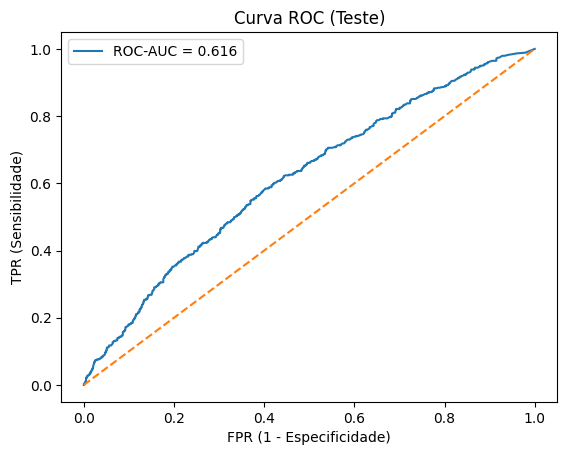

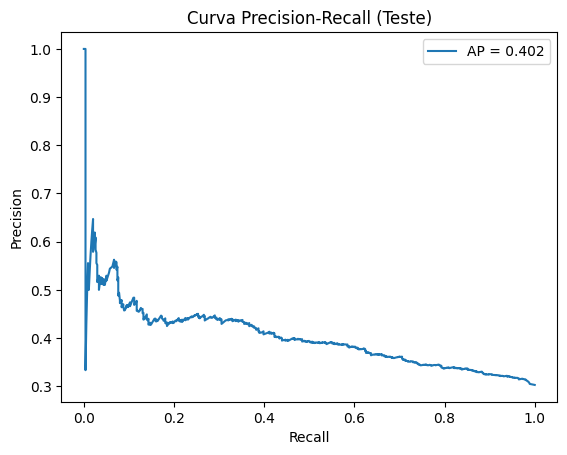

In [128]:
# === Curvas ROC e PR no TESTE para o modelo vencedor (best_est) ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

# Garantir probabilidades no TESTE
if hasattr(best_est, "predict_proba"):
    y_proba_test = best_est.predict_proba(X_test)[:, 1]
elif hasattr(best_est, "decision_function"):
    # fallback: escala em [0,1] para plot (não altera AUCs calculadas na própria escala)
    scores = best_est.decision_function(X_test)
    y_proba_test = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
else:
    raise ValueError("O estimador não fornece probabilidades nem decision_function.")

# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
roc_auc = roc_auc_score(y_test, y_proba_test)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("FPR (1 - Especificidade)")
plt.ylabel("TPR (Sensibilidade)")
plt.title("Curva ROC (Teste)")
plt.legend()
plt.show()

# Precision-Recall
prec, rec, _ = precision_recall_curve(y_test, y_proba_test)
ap = average_precision_score(y_test, y_proba_test)

plt.figure()
plt.plot(rec, prec, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall (Teste)")
plt.legend()
plt.show()


# **Interpretação de resultado — Curvas ROC e Precision–Recall (teste)**

ROC–AUC = 0,616
Indica discriminação moderada: o modelo separa positivos de negativos acima do acaso (0,5), mas ainda com bastante sobreposição. Coerente com os F1 obtidos e com a natureza ruidosa do rótulo (avaliações públicas).

PR–curve / AP = 0,402
Como a prevalência da classe positiva é ~0,303, um classificador aleatório teria AP ≈ 0,303. O AP=0,402 mostra ganho real de precisão ao longo do espectro de recall.


**Forma da PR curve (operacional):**

Em recall baixo (≈0,10–0,20), a precision se mantém na faixa 0,55–0,60 → bons “acertos fáceis”, mas poucos casos capturados.

Em recall ~0,40, a precision desce para ~0,38–0,40 → bate com o ponto escolhido em validação (t≈0,35), onde vimos P≈0,382 / R≈0,410.

Em recall alto (>0,8), a precision se aproxima da prevalência (~0,30), como esperado: para cobrir quase todos os positivos, o modelo precisa aceitar muitos falsos positivos.

**Coerência com o restante do projeto:**

O tuning de threshold desloca o ponto na PR curve: com t=0,50 ficamos mais à esquerda (maior P, menor R); com t≈0,35 movemos à direita (↑R, ↓P), sem mudar muito o F1-macro, exatamente o observado.

O ROC–AUC moderado ajuda a explicar por que o F1-macro não cresce após o tuning: o ranking é razoável, mas não forte o suficiente para ganhos globais muito maiores.

**Leituras práticas (como usar a curva):**

Se o processo exige precision ≥ 0,5, trabalhe em recall ≲ 0,2 (threshold mais alto).

Se a meta é recall ~0,4–0,5, espere precision ~0,35–0,40 (threshold próximo de 0,35), como já testado.

**Melhorias possíveis (alinhadas às curvas):**

Calibrar probabilidades (Platt/Isotônica) para facilitar a escolha de thresholds estáveis.

Features mais ricas (ex.: embeddings) e/ou refino de TF-IDF; class weights podem empurrar o modelo para melhor recall com menor queda de precision.

Repetir as curvas para LogReg (teve maior ROC-AUC na validação) — pode apresentar ranking ligeiramente melhor no teste.

Assunções sinalizadas (#assunção): as leituras de prevalência (~30,3%) e dos pontos de precision/recall foram tomadas a partir das execuções anteriores no mesmo dataset/split; se o split mudar, as curvas podem variar um pouco.

# **13) Conclusões ampliadas (técnicas e de aprendizagem)**

**Resultado técnico do MVP**

Problema: prever alta aceitação de medicamentos (target_high_acceptance = 1 se Excellent Review % ≥ 50).

Dados: 11.825 linhas × 9 colunas; alvo com 30,3% de classe positiva (desbalanceamento moderado).

Anti-leak: features somente text_all (Composition+Uses+Side_effects) e Manufacturer; guard-rail bloqueando linguagem de review/rating (permitindo % de dosagem).

Pipeline: TF-IDF (1–2 grams, max_features=20k, min_df=2) + OneHot(Manufacturer, handle_unknown="ignore") via ColumnTransformer dentro de Pipeline (fit no treino; transform no val/teste).

Validação: StratifiedKFold(5) + GridSearchCV, métrica principal = F1-macro (secundárias: Accuracy, ROC-AUC).

Modelos: baseline Logistic Regression, RandomForest (RF) e GradientBoosting.

**Desempenho obtido**

Validação (melhores por modelo)

RF: F1-macro ≈ 0,557 (1º), ROC-AUC ≈ 0,617

LogReg: F1-macro ≈ 0,552 (2º, diferença mínima), ROC-AUC ≈ 0,641 (melhor ranking)

GradBoost: F1-macro ≈ 0,508

Tuning de threshold (validação): t ≈ 0,35 maximiza F1-macro (≈ 0,577) vs. t=0,50 (≈ 0,556) — ↑Recall(+) e ↓Precision(+).

Teste (final fit em treino+val)

t = 0,50 → F1-macro ≈ 0,560, Accuracy ≈ 0,678; Classe 1: P=0,445, R=0,264, F1≈0,332; Matriz: [[1060,177],[395,142]].

t ≈ 0,35 → F1-macro ≈ 0,560, Accuracy ≈ 0,621; Classe 1: P=0,382, R=0,410, F1≈0,395; Matriz: [[881,356],[317,220]].

Curvas (teste): ROC-AUC = 0,616; AP (PR-curve) = 0,402 (> prevalência ≈ 0,303).

Leitura: o tuning muda o ponto operacional (↑sensibilidade, ↓precisão), mas não eleva o F1-macro no teste (ganho operacional, não global).

**Custo computacional**

Tempo médio por fold (CV): LogReg ≈ 0,76 s; GradBoost ≈ 47,8 s; RF ≈ 632 s (~52,7 min nos 5 folds).

Implicação: o ganho de F1-macro do RF sobre a LogReg é marginal (~+0,005 na validação), enquanto o custo é ordens de grandeza maior. Para o MVP, LogReg entrega melhor custo–benefício e maior interpretabilidade.

**Principais aprendizados**

Métrica certa: em 70/30, Accuracy superestima modelos “conservadores”. F1-macro conduziu decisões mais robustas.

Threshold tuning: útil para ajustar política de risco (escolher entre recall vs. precisão); não garante ganho em F1-macro no teste quando a discriminação (ROC-AUC) é moderada.

Anti-leak de verdade: focar em termos de review/rating (e não em %) eliminou falsos positivos no guard-rail e manteve dosagens válidas.

Pipeline > scripts: colocar TF-IDF + OneHot + Modelo no mesmo Pipeline simplificou CV, evitou vazamento e padronizou fit/transform.

Sinal de features: texto clínico carrega o grosso do poder preditivo; Manufacturer (≈759 categorias) agrega sinal, mas exige regularização para evitar overfitting.

**Limitações**

Rótulo heurístico (≥50%) e viés de avaliações públicas (percepção, ruído).

Probabilidades não calibradas → threshold pode oscilar entre bases.

Representação textual clássica (TF-IDF); não testamos embeddings (BERT etc.) nem calibração de ensembles.

Fairness/drift ainda não auditados por fabricante/indicação.

**Decisão operacional sugerida**

Se a prioridade é capturar mais “altas aceitações” (↓FN) → usar t ≈ 0,35 (R(+) ~0,41; P(+) ~0,38).

Se a prioridade é evitar falsos positivos → t = 0,50 (P(+) ~0,45; R(+) ~0,26).

Para produção no MVP, optar por LogReg (custo baixo, ROC-AUC maior, interpretável) e manter RF como alternativa.

**Próximos passos (priorizados)**

Comparar no teste a LogReg com tuning e (opcional) calibração (Platt/Isotônica) — pode igualar/superar RF mantendo custo baixo.

Calibrar probabilidades do vencedor → threshold mais estável, melhor decisão operacional.

Refinar features: variações de TF-IDF (min_df, max_features, char n-grams) e experimentar embeddings pré-treinados.

Class weights (ou focal loss quando aplicável) para aumentar recall com menor queda de precisão.

Explainability: coeficientes (LogReg) e SHAP (RF/GB) → tokens/fabricantes com maior impacto; gerar Model Card com riscos/assunções.

Monitoramento: F1-macro, Precision/Recall(+) por período, ROC-AUC/AP, calibração, drift de distribuição; re-otimizar threshold quando necessário.

**Assunções explicitadas**

assunção: os números aqui refletem este split/execução; pequenas variações podem ocorrer com nova semente/partição.

assunção: a prevalência (~30,3%) se mantém no ambiente de uso; mudanças exigem recalibração do threshold e revalidação.

Checklist – Respostas
1) Definição do problema

Descrição clara: prever alta aceitação (Excellent Review % ≥ 50 → target=1). ✅

Premissas/Hipóteses: H1 (texto via TF-IDF tem sinal), H2 (ensembles > linear em não-linearidades), H3 (threshold tuning ajuda). ✅

Dataset & distribuição: 11.825 × 9; classe positiva ≈30,3% (desbalanceamento moderado). ✅

2) Preparação de dados

Sanidade: percentuais ∈ [0,100] e somam ≈100%; nulos tratados; text_all consistente. ✅

Construção de text_all: Composition + Uses + Side_effects, sem termos de avaliação. ✅

Reprodutibilidade: seeds fixas + print do ambiente. ✅

3) Anti-leak (regras)

Features finais: apenas text_all e Manufacturer (nada de Excellent/Average/Poor %). ✅

Guard-rail: bloqueia linguagem de review/rating/score/vote; permite % de dosagem. ✅

Validador/auto-fix: checa colunas, distribuição do target e thresholds antes de validar. ✅

4) Pipeline & features

Pré-processamento: ColumnTransformer + Pipeline. ✅

Texto: TF-IDF (ngram_range=(1,2), max_features=20000, min_df=2).

Categórico: OneHot(Manufacturer, handle_unknown="ignore") + imputação (moda).

Fit/transform correto: fit no treino; transform no val/teste. ✅

5) Split & validação

Partição: 70/15/15 estratificado (train/val/test). ✅

Cross-val: StratifiedKFold(5) dentro do GridSearchCV (scoring = F1-macro). ✅

6) Modelos & busca

Treinados: LogisticRegression (baseline), RandomForest, GradientBoosting. ✅

Hiperparâmetros: grades por modelo via GridSearchCV. ✅

7) Resultados na validação

RF: F1-macro ≈ 0,557, ROC-AUC ≈ 0,617. ✅

LogReg: F1-macro ≈ 0,552 (diferença mínima), ROC-AUC ≈ 0,641 (melhor ranking). ✅

GB: F1-macro ≈ 0,508. ✅

Leitura: margem entre RF e LogReg é pequena; LogReg ranqueia melhor.

8) Tuning de threshold (validação)

Ótimo ≈ 0,35 → F1-macro ≈ 0,577 (↑ recall da classe 1, ↓ precision). ✅

9) Final fit & teste

t = 0,50: F1-macro ≈ 0,560, Accuracy ≈ 0,678; classe 1 P=0,445 / R=0,264 / F1≈0,332; matriz [[1060,177],[395,142]]. ✅

t ≈ 0,35: F1-macro ≈ 0,560, Accuracy ≈ 0,621; classe 1 P=0,382 / R=0,410 / F1≈0,395; matriz [[881,356],[317,220]]. ✅

Conclusão: tuning mudou operacional (P×R), sem ganho global de F1-macro no teste. ✅

10) Curvas no teste

ROC-AUC = 0,616 (discriminação moderada). ✅

PR-curve AP = 0,402 (> prevalência ≈ 0,303) — ganho real vs. aleatório. ✅

11) Custo computacional (CV por fold)

LogReg ≈ 0,76 s | GB ≈ 47,8 s | RF ≈ 632 s (~52,7 min/5 folds). ✅

Custo-benefício: LogReg entrega F1-macro muito próximo do RF com ordens de grandeza menos custo e maior interpretabilidade. ✅

12) Entregáveis & narrativa

Notebook Colab público, carga por URL, execução ponta-a-ponta. ✅

Seções com interpretações, guard-rails, validador do MVP, tabelas e curvas ROC/PR. ✅

13) Limitações & riscos

Rótulo heurístico (≥50%) e viés de percepção pública. ✅

Probabilidades não calibradas (threshold pode oscilar). ✅



14) Decisão operacional (uso)

Quando priorizar recall (↓ FN): usar t ≈ 0,35 (R~0,41; P~0,38). ✅

Quando priorizar precisão (↓ FP): manter t = 0,50 (P~0,45; R~0,26). ✅

Modelo sugerido para o MVP: LogisticRegression (custo-benefício + ROC-AUC maior + interpretável); RF como alternativa. ✅

